In [ ]:
%pip install gymnasium

In [2]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Arrow
from IPython.display import display, clear_output

# Environment

## Continuous observation-action space

In [7]:
class ContinuousUnicycleEnv(gym.Env):
    def __init__(self):
        super(ContinuousUnicycleEnv, self).__init__()

        # Boundaries for the robot
        self.min_x, self.max_x = -5.0, 5.0
        self.min_y, self.max_y = -5.0, 5.0
        self.max_linear_velocity = 1.0
        self.max_angular_velocity = 1.0

        # The action space is [linear_velocity, angular_velocity]
        self.action_space = spaces.Box(
            low=np.array([-self.max_linear_velocity, -self.max_angular_velocity]),
            high=np.array([self.max_linear_velocity, self.max_angular_velocity]),
            dtype=np.float32
        )

        # The observation space is {'state': [x, y, theta], 'relative_state': [ex, ey, etheta]} (position of goal relative to the robot)
        self.observation_space = {
            'state':spaces.Box(
                low=np.array([self.min_x, self.min_y, -np.pi]),
                high=np.array([self.max_x, self.max_y, np.pi]),
                dtype=np.float32
            ),
            'relative_state':spaces.Box(
                low=np.array([-(self.max_x - self.min_x), -(self.max_y - self.min_y), -np.pi]),
                high=np.array([(self.max_x - self.min_x), (self.max_x - self.min_x), np.pi]),
                dtype=np.float32
            )
        }

        # Parameters
        self.dt = 0.1  # time step
        self.initial_state = np.array([0.0, 0.0, 0.0])
        self.goal = np.array([4.0, 4.0, np.pi / 2])  # goal position and angle

        self.state = np.array([0.0, 0.0, 0.0])
        self.relative_state = self.get_relative_state()

        # Rendering setup
        self.path = []
        self.fig, self.ax = plt.subplots()

    def reset(self, exploring=False):
        """
        Resets the environment to an initial state and returns the initial observation.
        """
        if exploring:
            self.state = [
                self.min_x + np.random.rand()*(self.max_x - self.min_x),
                self.min_y + np.random.rand()*(self.max_y - self.min_y),
                -np.pi + 2*np.pi*np.random.rand()
                ]
        else:
            self.state = self.initial_state.copy()

        self.relative_state = self.get_relative_state()
        self.path = [self.state[:2].copy()]  # Initialize path with the start position

        return self.get_obs()

    def step(self, action):
        """
        Executes one time step within the environment.
        """
        # Clip the action to respect the velocity limits
        linear_velocity = np.clip(action[0], -self.max_linear_velocity, self.max_linear_velocity)
        angular_velocity = np.clip(action[1], -self.max_angular_velocity, self.max_angular_velocity)

        x, y, theta = self.state

        # Update state
        x += linear_velocity * np.cos(theta) * self.dt
        y += linear_velocity * np.sin(theta) * self.dt
        theta += angular_velocity * self.dt

        # Clip x and y to stay within the bounds
        x = np.clip(x, self.min_x, self.max_x)
        y = np.clip(y, self.min_y, self.max_y)

        # Normalize theta to be within [-pi, pi]
        theta = (theta + np.pi) % (2 * np.pi) - np.pi

        self.state = np.array([x, y, theta])
        self.relative_state = self.get_relative_state()

        # Save the current position to the path
        self.path.append(self.state[:2].copy())

        reward = self.get_reward()
        done = self.is_done()

        return self.get_obs(), reward, done, {}

    def get_relative_state(self):
        """
        Transforms the goal position to be relative to the robot's current position and orientation.
        """
        x, y, theta = self.state
        goal_x, goal_y, goal_theta = self.goal

        # Calculate relative position
        dx = goal_x - x
        dy = goal_y - y

        # Rotate to the robot's frame of reference
        ex = np.cos(theta) * dx + np.sin(theta) * dy
        ey = -np.sin(theta) * dx + np.cos(theta) * dy
        etheta = goal_theta - theta

        # Normalize etheta to be within [-pi, pi]
        etheta = (etheta + np.pi) % (2 * np.pi) - np.pi

        return np.array([ex, ey, etheta])

    def get_obs(self):
        return {'state': self.state, 'relative_state': self.relative_state}

    def render(self, mode='human'):
        """
        Renders the environment using Matplotlib.
        """
        x, y, theta = self.state
        self.ax.clear()

        # Set the plot boundaries with extra space around the robot's operating area
        buffer = 1.0
        self.ax.set_xlim(self.min_x - buffer, self.max_x + buffer)
        self.ax.set_ylim(self.min_y - buffer, self.max_y + buffer)

        # Plot the bounds of the space with solid lines
        self.ax.add_patch(Rectangle((self.min_x, self.min_y), self.max_x - self.min_x, self.max_y - self.min_y,
                                    fill=None, edgecolor='k', linestyle='-', linewidth=2))

        # Plot the goal
        goal_x, goal_y, goal_theta = self.goal
        self.ax.plot(goal_x, goal_y, 'ro', label='Goal')
        self.ax.add_patch(Arrow(goal_x, goal_y, 0.5 * np.cos(goal_theta), 0.5 * np.sin(goal_theta),
                                width=0.2, color='r'))

        # Plot the start position
        self.ax.plot(0.0, 0.0, 'go', label='Start')

        # Plot the robot's path
        path = np.array(self.path)
        self.ax.plot(path[:, 0], path[:, 1], 'k--', label='Path')

        # Plot the robot as a solid rectangle
        width, height = 0.5, 0.3
        robot = Rectangle(
            (x - 0.5 * width, y - 0.5 * height), width, height, angle=np.degrees(theta), rotation_point='center',
            edgecolor='b', facecolor='b'
        )
        self.ax.add_patch(robot)
        self.ax.add_patch(Arrow(x, y,  0.5 * np.cos(theta*np.pi/4), 0.5 * np.sin(theta*np.pi/4),
                                width=0.4, color='b'))

        # Plot settings
        self.ax.set_aspect('equal', adjustable='box')
        self.ax.legend()
        self.ax.grid(True)

        # Update the plot
        clear_output(wait=True)
        display(self.fig)
        plt.pause(0.001)

    def close(self):
        plt.close(self.fig)

    def get_reward(self):
        # return: float (reward)
        x, y, theta = self.state
        ex, ey, etheta = self.relative_state

        # Implement code here
        reward = 10

        return reward

    def is_done(self):
        # return: bool (True if done, False otherwise)
        x, y, theta = self.state
        ex, ey, etheta = self.relative_state

        # Implement code here
        done = False

        return done

# Run with graphics

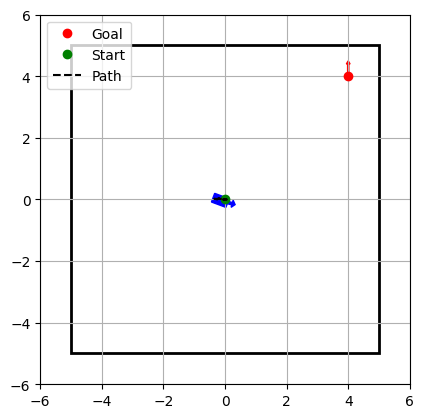

In [8]:
env = ContinuousUnicycleEnv()
obs = env.reset(exploring=False)
done = False

for _ in range(20):
    action = env.action_space.sample()  # Random action
    obs, reward, done, info = env.step(action)
    env.render()
env.close()

In [9]:
print(env.action_space)
print(env.observation_space)

Box(-1.0, 1.0, (2,), float32)
{'state': Box([-5.        -5.        -3.1415927], [5.        5.        3.1415927], (3,), float32), 'relative_state': Box([-10.        -10.         -3.1415927], [10.        10.         3.1415927], (3,), float32)}


# Headless Render (for training)

In [11]:
env = ContinuousUnicycleEnv()
obs = env.reset(exploring=False)
done = False

for _ in range(20):
    action = env.action_space.sample()  # Random action
    obs, reward, done, info = env.step(action)
    print(obs)
env.close()

{'state': array([ 0.08767715,  0.        , -0.01783801]), 'relative_state': array([3.84035217, 4.06914798, 1.58863434])}
{'state': array([ 0.04056993,  0.00084039, -0.0141551 ]), 'relative_state': array([3.90242679, 4.05480323, 1.58495143])}
{'state': array([-0.01146337,  0.00157697,  0.04205356]), 'relative_state': array([4.17601513, 3.82624132, 1.52874276])}
{'state': array([-0.01300939,  0.00151192,  0.05233718]), 'relative_state': array([4.21668853, 3.78307932, 1.51845915])}
{'state': array([0.01117299, 0.00277871, 0.06740612]), 'relative_state': array([4.24900186, 3.71947606, 1.5033902 ])}
{'state': array([ 0.04603593,  0.00513226, -0.01875722]), 'relative_state': array([3.8783403 , 4.06832602, 1.58955355])}
{'state': array([0.05066329, 0.00504545, 0.06764914]), 'relative_state': array([4.21035244, 3.71885126, 1.50314718])}
{'state': array([0.07083684, 0.00641226, 0.03245957]), 'relative_state': array([4.05670079, 3.8639675 , 1.53833676])}
{'state': array([0.00580156, 0.0043005 , 